# 第一步：导入必要的库

In [16]:
%matplotlib inline

In [17]:
import xgboost as xgb

In [18]:
from sklearn import cross_validation

In [19]:
import numpy as np
import dicom
import glob
from matplotlib import pyplot as plt
import os
import cv2
import mxnet as mx
import pandas as pd

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 第二步：获取所有病人数据

## 2.1 读取所有病人图像路径

In [20]:
patients_folder_path = glob.glob('/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/*')
print("len(patients_folder_path):{0}".format(len(patients_folder_path)))
for idx in xrange(len(patients_folder_path[:10])):
    print(idx, patients_folder_path[idx]) 

len(patients_folder_path):1595
(0, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0015ceb851d7251b8f399e39779d1e7d')
(1, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0030a160d58723ff36d73f41b170ec21')
(2, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/003f41c78e6acfa92430a057ac0b306e')
(3, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/006b96310a37b36cccb2ab48d10b49a3')
(4, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/008464bb8521d09a42985dd8add3d0d2')
(5, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0092c13f9e00a3717fdc940641f00015')
(6, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/024efb7a1e67dc820eb61cbdaa090166')
(7, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0257df465d9e4150adef13303433ff1e')
(8, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/026470d51482c93efc18b9803159c960')
(9, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0268f3a7a17412178cfb039e71799a80')


In [21]:
def get_patients_data_dir(path):
    '''
    获取到所有病人的目录，返回的结果是一个list，
    包含该目录下所有病人的目录。
    '''
    patients_folder_path_list = glob.glob(path)
    # 打印所有目录
    print("type(patients_folder_path_list):{0}".format(type(patients_folder_path_list)))
    print("len(patients_folder_path_list):{0}".format(len(patients_folder_path_list)))
    for idx in xrange(len(patients_folder_path_list[:10])):
        print(idx, patients_folder_path_list[idx])
    return patients_folder_path_list

In [22]:
path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/*'
patients_folder_path_list = get_patients_data_dir(path)

type(patients_folder_path_list):<type 'list'>
len(patients_folder_path_list):1595
(0, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0015ceb851d7251b8f399e39779d1e7d')
(1, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0030a160d58723ff36d73f41b170ec21')
(2, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/003f41c78e6acfa92430a057ac0b306e')
(3, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/006b96310a37b36cccb2ab48d10b49a3')
(4, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/008464bb8521d09a42985dd8add3d0d2')
(5, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0092c13f9e00a3717fdc940641f00015')
(6, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/024efb7a1e67dc820eb61cbdaa090166')
(7, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0257df465d9e4150adef13303433ff1e')
(8, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/026470d51482c93efc18b9803159c960')
(9, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0268f3a7a1741

## 2.2 根据路径读取dicom图像
读取完成后，将仅包含图像的部分转换为numpy数组（注：一个病人是一个list数据结构，而list中每张切片是一个Numpy二维数组），并实现转存（发现保存前后和原始dicom图像大小基本一致）。

下面获取第一个病人的图像路径，并做一列操作。

In [23]:
# 获取某病人的图像序列slices
folder_path = patients_folder_path_list[0]
print("folder_path:{0}".format(folder_path))
slices = [dicom.read_file(folder_path + '/' + s) for s in os.listdir(folder_path)]
print("len(slices):{0}".format(len(slices)))
print("type(slices):{0}".format(type(slices)))

# 查看某病人图像序列的其中一张
print("============================================")
print("slices[0].PatientName:{0}".format(slices[0].PatientName))
print("slices[0].PatientID:{0}".format(slices[0].PatientID))
print("slices[0]:{0}".format(slices[0]))
slices.sort(key=lambda x: int(x.InstanceNumber))
print("============================================")

# 将某病人的所有图像数据打包为numpy数组
sample_image = np.stack([s.pixel_array for s in slices])
print("len(sample_image):{0}".format(len(sample_image)))
print("type(sample_image):{0}".format(type(sample_image)))
print("sample_image.shape:{0}".format(sample_image.shape))

# 引入sys模块查看保存某病人所有图像切片所需要的空间
# 和原始dicom数据大小基本一致
import sys
print("sys.getsizeof(sample_image):{0}".format(sys.getsizeof(sample_image)))
np.save("sample_image.npy", sample_image)

folder_path:/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0015ceb851d7251b8f399e39779d1e7d
len(slices):195
type(slices):<type 'list'>
slices[0].PatientName:0015ceb851d7251b8f399e39779d1e7d
slices[0].PatientID:0015ceb851d7251b8f399e39779d1e7d
slices[0]:(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.266857665440469517895487635133
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) K

In [24]:
rm sample_image.npy

将以上过程封装成函数，对单独病人的图像读取并返回一个slices。封装后函数如下：

In [25]:
# 根据指定某病人路径读取CT扫描图像
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # 根据ImagePositionPatient属性进行排序
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    # 计算切片厚度
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [26]:
print(512**2*2)
print(512**2*2*195)

524288
102236160


In [27]:
slices = load_scan(patients_folder_path_list[0])

## 2.3 对单个病人的图像进行简单处理
1. 转换大小为int16
2. 将扫描外围的像素值设定为0或最小值
3. 转换为Hounsfield units (HU)单位
4. 最后将整个病人的一系列CT图全部转为numpy格式

In [28]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # 转换为int16(有时本身就是int16)
    image = image.astype(np.int16)

    # 设定扫描外围的像素值为0
    # 截距通常为-1024，所以空气约为0
    # image[image == -2000] = 0
    outside_image = image.min()
    image[image == outside_image] = 0
    
    # 转换为Hounsfield units (HU)
    for slice_idx in xrange(len(slices)):
        
        intercept = slices[slice_idx].RescaleIntercept
        slope = slices[slice_idx].RescaleSlope
        
        print("slice_idx:{}, intercept:{}, slope:{}".format(slice_idx, intercept, slope))
        
        if slope != 1:
            image[slice_idx] = slope * image[slice_idx].astype(np.float64)
            image[slice_idx] = image[slice_idx].astype(np.int16)
            
        image[slice_idx] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

我们对第一个病人得到的切片数据slices进行检查，因为还没转换HU，所以目前还是list类型。

In [29]:
print("type(slices):{0}".format(type(slices)))
print("len(slices):{0}".format(len(slices)))

first_patient_slices_hu = get_pixels_hu(slices)

print("first_patient_slices_hu.shape:{0}".format(first_patient_slices_hu.shape))

type(slices):<type 'list'>
len(slices):195
slice_idx:0, intercept:-1024, slope:1
slice_idx:1, intercept:-1024, slope:1
slice_idx:2, intercept:-1024, slope:1
slice_idx:3, intercept:-1024, slope:1
slice_idx:4, intercept:-1024, slope:1
slice_idx:5, intercept:-1024, slope:1
slice_idx:6, intercept:-1024, slope:1
slice_idx:7, intercept:-1024, slope:1
slice_idx:8, intercept:-1024, slope:1
slice_idx:9, intercept:-1024, slope:1
slice_idx:10, intercept:-1024, slope:1
slice_idx:11, intercept:-1024, slope:1
slice_idx:12, intercept:-1024, slope:1
slice_idx:13, intercept:-1024, slope:1
slice_idx:14, intercept:-1024, slope:1
slice_idx:15, intercept:-1024, slope:1
slice_idx:16, intercept:-1024, slope:1
slice_idx:17, intercept:-1024, slope:1
slice_idx:18, intercept:-1024, slope:1
slice_idx:19, intercept:-1024, slope:1
slice_idx:20, intercept:-1024, slope:1
slice_idx:21, intercept:-1024, slope:1
slice_idx:22, intercept:-1024, slope:1
slice_idx:23, intercept:-1024, slope:1
slice_idx:24, intercept:-1024, 

## 2.4 原始数据的二维可视化
HU值（hounsfield unit ，HU）是测定人体某一局部组织或器官密度大小的一种计量单位，通常称亨氏单位（hounsfield unit ，HU）空气为-1000，致密骨为+1000。

![HU examples][1]
[1]: http://i.imgur.com/4rlyReh.png

我们对未经处理的原始数据进行二维可视化，并将某病人某个切片的HU进行统计得到如下二维切片和HU直方图。

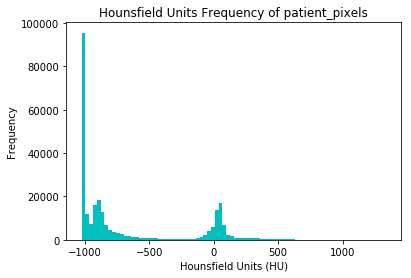

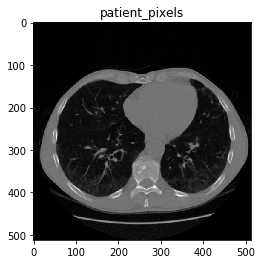

In [30]:
plt.hist(first_patient_slices_hu[80].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.title("Hounsfield Units Frequency of patient_pixels")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_slices_hu[80], cmap=plt.cm.gray)
plt.title("patient_pixels")
plt.show()

## 2.5 原始数据的三维可视化
由于每个病人的CT图像是一个组CT图像序列，整体来看是一个三维的，而单张只是这个三维的一张切片。因此，我们可以将一个病人的所有图像序列绘制成三维的进行可视化。似乎有几个库与三维可视化有关的，记得导入一下库：
```Python
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
```
CT扫描图像的3D可视化是很有用的。Kaggle docker镜像中提供的软件包在这个比赛中发挥的作用比较受限，我们使用marching cubes算法创建一个3D对象的近似网格，并用matplotlib绘图。虽然这个过程比较慢而且画出来有点丑，但这也不错了。

In [31]:
from skimage import measure, morphology

def plot_3d(image, threshold=-300):
    ## 垂直放置扫描，
        ## 所以患者的头部将在顶部面向相机
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

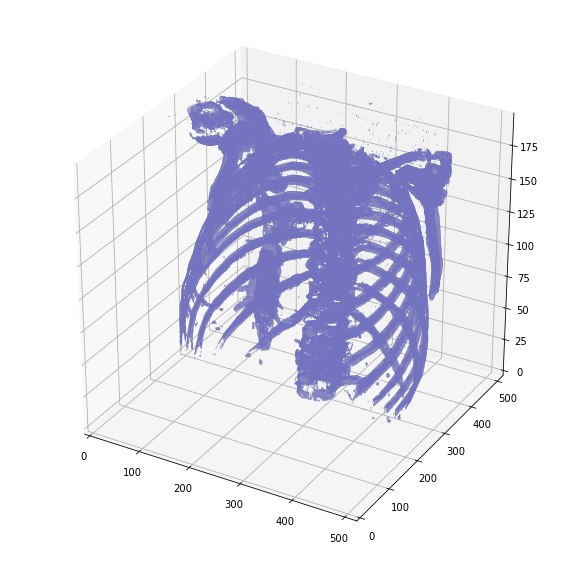

In [32]:
plot_3d(first_patient_slices_hu, 400)

## 整合数读取过程
将第二个步骤，以上提到的几个过程，总结写到一起：

1. 读取所有病人图像路径
2. 根据路径读取dicom图像

这一步骤，主要包含下面三个函数：

1. 读取所有病人的目录
2. 读取某病人的所有CT扫描图像得到该病人扫描图像切片序列slices
3. 读取该病人扫描图像序列slices的HU值，并转为numpy数组

In [33]:
def get_patients_data_dir(path):
    '''
    获取到所有病人的目录，返回的结果是一个list，
    包含该目录下所有病人的目录。
    '''
    patients_folder_path_list = glob.glob(path)
    # 打印所有目录
#     print("type(patients_folder_path_list):{0}".format(type(patients_folder_path_list)))
#     print("len(patients_folder_path_list):{0}".format(len(patients_folder_path_list)))
    for idx in xrange(len(patients_folder_path_list[:10])):
        print(idx, patients_folder_path_list[idx])
    return patients_folder_path_list

In [34]:
# 根据指定某病人路径读取CT扫描图像
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # 根据ImagePositionPatient属性进行排序
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    # 计算切片厚度
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [35]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # 转换为int16(有时本身就是int16)
    image = image.astype(np.int16)

    # 设定扫描外围的像素值为0
    # 截距通常为-1024，所以空气约为0
    # image[image == -2000] = 0
    outside_image = image.min()
    image[image == outside_image] = 0
    
    # 转换为Hounsfield units (HU)
    for slice_idx in xrange(len(slices)):
        
        intercept = slices[slice_idx].RescaleIntercept
        slope = slices[slice_idx].RescaleSlope
        
        #print("slice_idx:{}, intercept:{}, slope:{}".format(slice_idx, intercept, slope))
        
        if slope != 1:
            image[slice_idx] = slope * image[slice_idx].astype(np.float64)
            image[slice_idx] = image[slice_idx].astype(np.int16)
            
        image[slice_idx] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [36]:
# 变量初始化
path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/*'
patients_folder_path_list = get_patients_data_dir(path)
print("len(patients_folder_path_list)):{0}".format(len(patients_folder_path_list)))

# 遍历读取每个病人的路径，dicom图像序列slices，获取该slices的所有hu值

from time import clock
# 计时开始
start = clock()
repeat_times = 5

#for p_idx in xrange(len(patients_folder_path_list)):
for p_idx in xrange(repeat_times):
    print("p_idx:{0}".format(p_idx))
    folder_path = patients_folder_path_list[p_idx]
    slices = load_scan(folder_path)
    hu_slices = get_pixels_hu(slices)
    
# 计时结束
finish = clock()
print("(finish-start)/float(repeat_times):{0}".format((finish-start)/float(repeat_times)))

(0, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0015ceb851d7251b8f399e39779d1e7d')
(1, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0030a160d58723ff36d73f41b170ec21')
(2, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/003f41c78e6acfa92430a057ac0b306e')
(3, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/006b96310a37b36cccb2ab48d10b49a3')
(4, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/008464bb8521d09a42985dd8add3d0d2')
(5, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0092c13f9e00a3717fdc940641f00015')
(6, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/024efb7a1e67dc820eb61cbdaa090166')
(7, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0257df465d9e4150adef13303433ff1e')
(8, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/026470d51482c93efc18b9803159c960')
(9, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0268f3a7a17412178cfb039e71799a80')
len(patients_folder_path_list)):1595
p_idx:0
p_idx:1
p_idx:2

# 第三步：数据预处理
主要包含如下四个小步骤，我会在每个步骤之后对其进行可视化。
1. 空间重采样
2. 肺部区域分割
3. 标准化
4. 去均值

## 3.1 空间重采样(Resampling)
CT扫描图像的像素间距可能为[2.5, 0.5, 0.5]，这意味着切片之间的距离是2.5毫米。对于不同的扫描图像，也可能是[1.5,0.725,0.725]，这对于使用自动化的分析算法（如使用ConvNets）是有问题的！

处理这种情况的一种常见方法是将整个数据集重新采样为某种各向同性的分辨率。如果选择将所有像素重新采样到[1mm,1mm,1mm]像素，可以使用3D convnets，而不必担心学习缩放/切片厚度不变性。

虽然这看起来像是一个非常简单的步骤，但由于四舍五入，它有很多边缘情况。此外，它需要很长时间。下面的代码可以处理得很好（并处理边缘情况）：

In [37]:
def resample(image, scan, new_spacing=[1.,1.,1.]):
    # image:提取了hu的numpy数组（图像序列）
    # scan:这个是一个list，每个元素是当前病人的CT扫描单张切片（Numpy数据结构）
    # 确定当前像素间距
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

请注意，重采样后会使用新的间距！由于四舍五入可能会略微偏离所我们最希望的间距（上面的脚本会对最后期望的间距进行四舍五入）。下面让我们执行一下折断代码，获得[1mm,1mm,1mm]像素的空间间距。

In [38]:
pix_resampled, spacing = resample(first_patient_slices_hu, slices, [1,1,1])
print("Shape before resampling\t", first_patient_slices_hu.shape)
print("Shape after resampling\t", pix_resampled.shape)

('Shape before resampling\t', (195, 512, 512))
('Shape after resampling\t', (390, 370, 370))


(390, 370, 370)


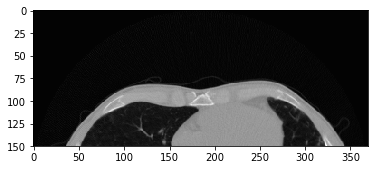

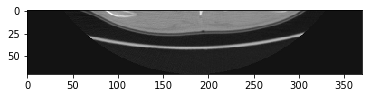

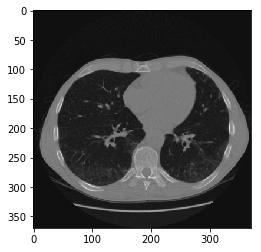

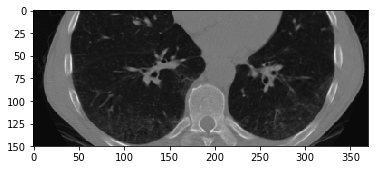

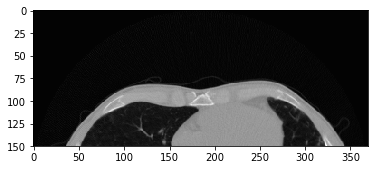

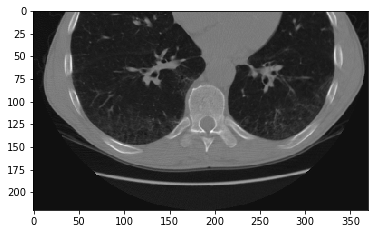

In [39]:
#print pix_resampled
print pix_resampled.shape
# Show some slice in the middle
plt.imshow(pix_resampled[170][:150][:150], cmap=plt.cm.gray)
plt.show()
plt.figure(2)
plt.imshow(pix_resampled[170][150:][150:], cmap=plt.cm.gray)
plt.show()
plt.figure(3)
plt.imshow(pix_resampled[170], cmap=plt.cm.gray)
plt.show()

plt.figure(4)
plt.imshow(pix_resampled[170][150:][:150], cmap=plt.cm.gray)
plt.show()

plt.figure(5)
plt.imshow(pix_resampled[170][:150], cmap=plt.cm.gray)
plt.show()

plt.figure(6)
plt.imshow(pix_resampled[170][150:], cmap=plt.cm.gray)
plt.show()

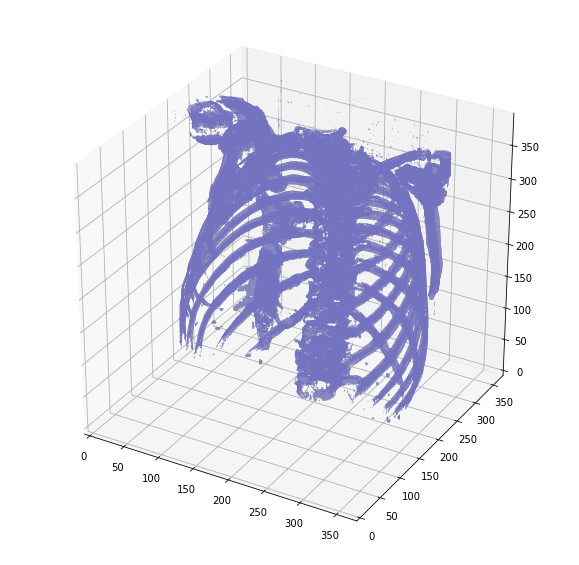

In [40]:
plot_3d(pix_resampled, 400)

## 3.2 肺部区域分割

为了减少问题空间，我们可以对肺进行分割（通常肺周围会有围绕的组织）。这个分割步骤有相当多的自动化过程：包括一系列区域生长和形态运算的。在当前情况下，我们将仅使用连通分量分析。  
步骤：
* 对图像取阈值（-320 HU是一个很好的阈值，但对这种方法没有多大影响）
* 做连接的组件，确定人体周围的空气标签，在二进制图像中填充1
* 可选：对于扫描中的每个轴向切片，确定最大的实体连接分量（人体周围的人体+空气），并将其他设置为0。这将填充遮罩中肺部的结构。
只保留最大的气穴（人体有很多气穴）。

In [41]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [42]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

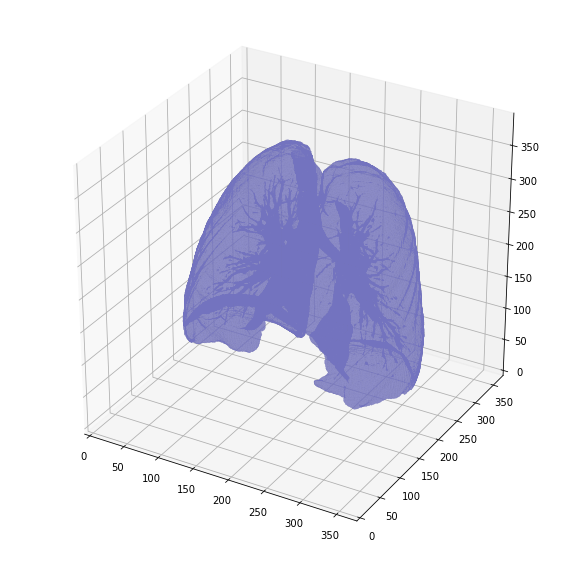

In [43]:
plot_3d(segmented_lungs, 0)

Beautiful! 

But there's one thing we can fix, it is probably a good idea to include structures within the lung (as <font color=red>the nodules are solid</font>), we do not only want to air in the lungs. 

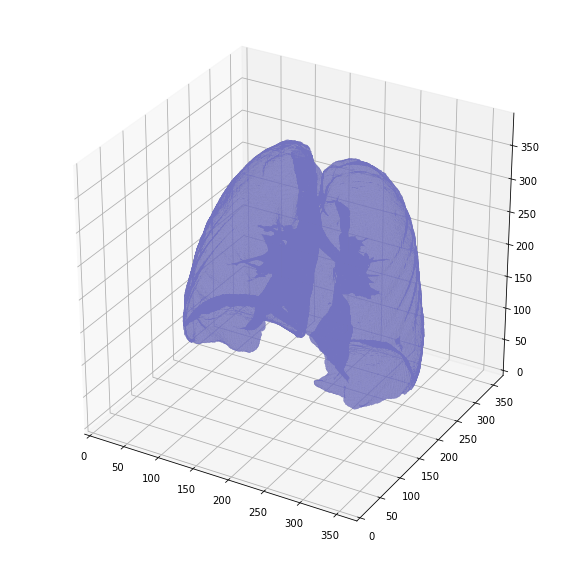

In [44]:
plot_3d(segmented_lungs_fill, 0)

看来很棒，也可以将两幅图的差进行可视化：

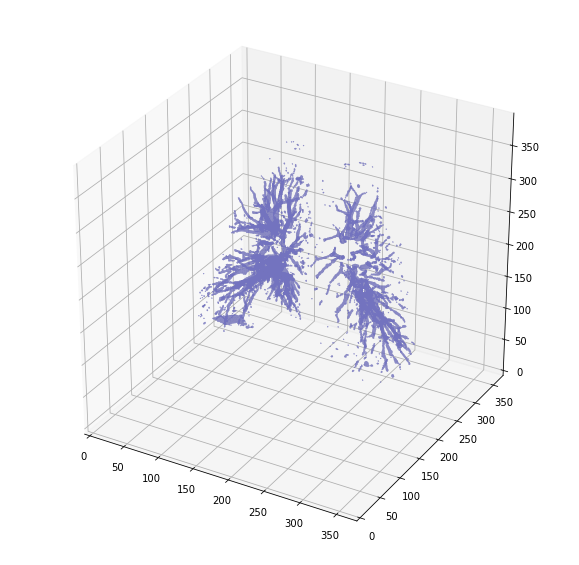

In [45]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

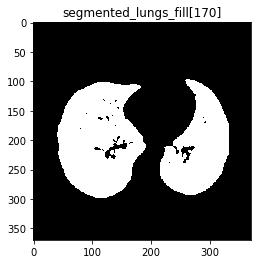

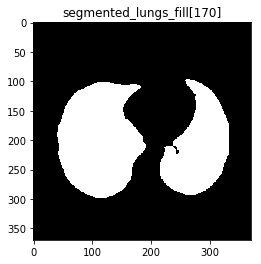

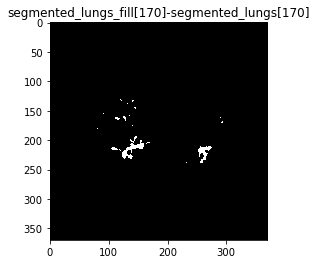

In [46]:
plt.imshow(segmented_lungs[170], cmap=plt.cm.gray)
plt.title('segmented_lungs_fill[170]')
plt.show()

plt.imshow(segmented_lungs_fill[170], cmap=plt.cm.gray)
plt.title('segmented_lungs_fill[170]')
plt.show()

plt.imshow(segmented_lungs_fill[170]-segmented_lungs[170], cmap=plt.cm.gray)
plt.title('segmented_lungs_fill[170]-segmented_lungs[170]')
plt.show()

当使用蒙版时记得先应用扩张形态操作（即使用圆形核）。这将在所有方向扩展蒙版。肺中的空气+结构不会包含所有的结节，对于粘在肺侧面的部分结节才会丢失，所以扩大一点蒙版也没关系:)

对于某些边缘情况，分割可能不好。它依赖于以下情况：患者外部连接到肺中的空气不连通。如果患者有气管造口术，则不会是这种情况，我不知道这是否存在于数据集中。此外，特别嘈杂的图像（例如由于下面的图像中的起搏器）这种方法也可能失败。相反，体内的第二大气穴将被分割。你可以通过检查蒙版对应的图像分数来识别这种情况，这种情况是少数的。然后，您可以首先应用一个几何尺寸的内核形态闭合操作，将这些孔闭合，之后它就能正常工作（或简而言之，不要使用该图像的蒙版）。


![pacemaker example][1]
  [1]: http://i.imgur.com/po0eX1L.png
  
将做了肺部区域分割后的图像进行二维可视化：

(390, 370, 370)


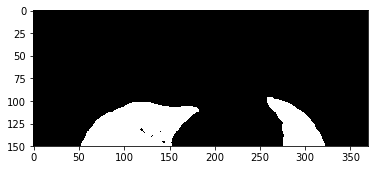

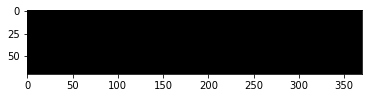

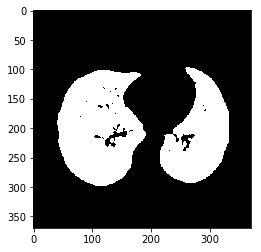

In [47]:
#print segmented_lungs
print segmented_lungs.shape
# Show some slice in the middle
plt.imshow(segmented_lungs[170][:150][:150], cmap=plt.cm.gray)
plt.show()
plt.figure(2)
plt.imshow(segmented_lungs[170][150:][150:], cmap=plt.cm.gray)
plt.show()
plt.figure(3)
plt.imshow(segmented_lungs[170], cmap=plt.cm.gray)
plt.show()

## 3.3 规范化(Normalization)

HU值的范围从-1024到2000左右。任何超过400的都不是我们感兴趣的，因为这些只是骨骼，具有不同的放射强度。在LUNA16比赛中常用的一组阈值是-1000和400之间的标准化。这里有一些代码可以使用：

In [48]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

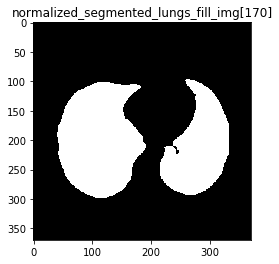

normalized_segmented_lungs_fill_img.shape):(390, 370, 370)
normalized_segmented_lungs_fill_img[170].shape:(370, 370)
normalized_segmented_lungs_fill_img[170].max():0.715
normalized_segmented_lungs_fill_img[170].min():0.714285714286


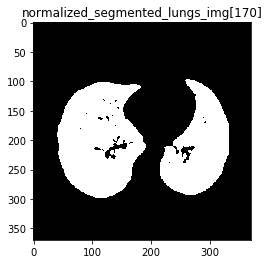

normalized_segmented_lungs_img.shape:(390, 370, 370)
normalized_segmented_lungs_img[170].shape:(370, 370)
normalized_segmented_lungs_img[170].max():0.715
normalized_segmented_lungs_img[170].min():0.714285714286


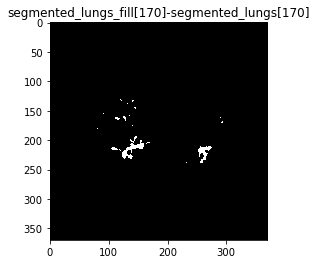

(segmented_lungs_fill[170]-segmented_lungs[170]).shape:(370, 370)
(segmented_lungs_fill[170]-segmented_lungs[170]).shape:(370, 370)
(segmented_lungs_fill[170]-segmented_lungs[170]).max():0.715
(segmented_lungs_fill[170]-segmented_lungs[170]).min():0


In [49]:
normalized_segmented_lungs_fill_img = normalize(segmented_lungs_fill)
normalized_segmented_lungs_img = normalize(segmented_lungs)

plt.imshow(normalized_segmented_lungs_fill_img[170], cmap=plt.cm.gray)
plt.title('normalized_segmented_lungs_fill_img[170]')
plt.show()
print("normalized_segmented_lungs_fill_img.shape):{0}".format(normalized_segmented_lungs_fill_img.shape))
print("normalized_segmented_lungs_fill_img[170].shape:{0}".format(normalized_segmented_lungs_fill_img[170].shape))
print("normalized_segmented_lungs_fill_img[170].max():{0}".format(normalized_segmented_lungs_fill_img[170].max()))
print("normalized_segmented_lungs_fill_img[170].min():{0}".format(normalized_segmented_lungs_fill_img[170].min()))

plt.imshow(normalized_segmented_lungs_img[170], cmap=plt.cm.gray)
plt.title('normalized_segmented_lungs_img[170]')
plt.show()
print("normalized_segmented_lungs_img.shape:{0}".format(normalized_segmented_lungs_img.shape))
print("normalized_segmented_lungs_img[170].shape:{0}".format(normalized_segmented_lungs_img[170].shape))
print("normalized_segmented_lungs_img[170].max():{0}".format(normalized_segmented_lungs_img[170].max()))
print("normalized_segmented_lungs_img[170].min():{0}".format(normalized_segmented_lungs_img[170].min()))

plt.imshow(segmented_lungs_fill[170]-segmented_lungs[170], cmap=plt.cm.gray)
plt.title('segmented_lungs_fill[170]-segmented_lungs[170]')
plt.show()
print("(segmented_lungs_fill[170]-segmented_lungs[170]).shape:{0}".format((segmented_lungs_fill[170]-segmented_lungs[170]).shape))
print("(segmented_lungs_fill[170]-segmented_lungs[170]).shape:{0}".format((segmented_lungs_fill[170]-segmented_lungs[170]).shape))
print("(segmented_lungs_fill[170]-segmented_lungs[170]).max():{0}".format(normalized_segmented_lungs_img[170].max()))
print("(segmented_lungs_fill[170]-segmented_lungs[170]).min():{0}".format((segmented_lungs_fill[170]-segmented_lungs[170]).min()))

# 3.4 去均值(Zero centering)

作为最后的预处理步骤，建议将数据的中心置零，也就是说使这一组数的平均值为0。为此，您只需从所有像素中减去平均像素值即可。

注：减去的这个平均值，是基于所有（患者）数据的像素平均值，而不是一张图像或者一个患者的所有图像。这需要做很多统计工作，我们发现在LUNA16比赛中这个平均值大约是0.25。

警告：不要使每个图像的平均值为零（像在这里的一些内核中做的那样）。CT扫描仪被校准以返回精确的HU测量。 没有像在正常图片中那样具有较低对比度或亮度的图像这样的东西。  
Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.

In [50]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

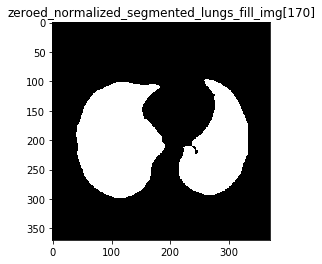

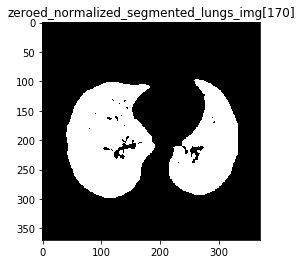

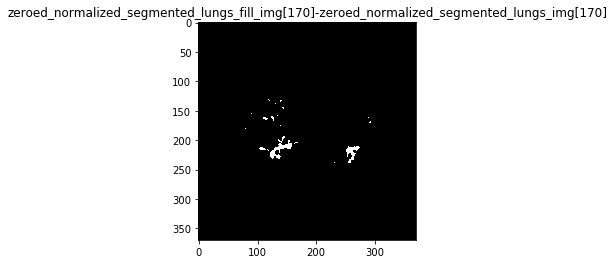

In [51]:
zeroed_normalized_segmented_lungs_fill_img =  zero_center(normalized_segmented_lungs_fill_img)
zeroed_normalized_segmented_lungs_img =  zero_center(normalized_segmented_lungs_img)

plt.imshow(zeroed_normalized_segmented_lungs_fill_img[170], cmap=plt.cm.gray)
plt.title('zeroed_normalized_segmented_lungs_fill_img[170]')
plt.show()

plt.imshow(zeroed_normalized_segmented_lungs_img[170], cmap=plt.cm.gray)
plt.title('zeroed_normalized_segmented_lungs_img[170]')
plt.show()

plt.imshow(zeroed_normalized_segmented_lungs_fill_img[170]-zeroed_normalized_segmented_lungs_img[170], cmap=plt.cm.gray)
plt.title('zeroed_normalized_segmented_lungs_fill_img[170]-zeroed_normalized_segmented_lungs_img[170]')
plt.show()

In [52]:
print("zeroed_normalized_segmented_lungs_fill_img.shape:{0}".format(zeroed_normalized_segmented_lungs_fill_img.shape))
print("zeroed_normalized_segmented_lungs_fill_img[170].max():{0}".format(zeroed_normalized_segmented_lungs_fill_img[170].max()))
print("zeroed_normalized_segmented_lungs_fill_img[170].min():{0}".format(zeroed_normalized_segmented_lungs_fill_img[170].min()))
print("zeroed_normalized_segmented_lungs_fill_img[170]:{0}".format(zeroed_normalized_segmented_lungs_fill_img[170]))

zeroed_normalized_segmented_lungs_fill_img.shape:(390, 370, 370)
zeroed_normalized_segmented_lungs_fill_img[170].max():0.465
zeroed_normalized_segmented_lungs_fill_img[170].min():0.464285714286
zeroed_normalized_segmented_lungs_fill_img[170]:[[ 0.46428571  0.46428571  0.46428571 ...,  0.46428571  0.46428571
   0.46428571]
 [ 0.46428571  0.46428571  0.46428571 ...,  0.46428571  0.46428571
   0.46428571]
 [ 0.46428571  0.46428571  0.46428571 ...,  0.46428571  0.46428571
   0.46428571]
 ..., 
 [ 0.46428571  0.46428571  0.46428571 ...,  0.46428571  0.46428571
   0.46428571]
 [ 0.46428571  0.46428571  0.46428571 ...,  0.46428571  0.46428571
   0.46428571]
 [ 0.46428571  0.46428571  0.46428571 ...,  0.46428571  0.46428571
   0.46428571]]


## 整合数据预处理过程

1. 空间重采样
2. 肺部区域分割
3. 标准化
4. 去均值

融合第二部分的代码（数据读取），我们并将主要的函数写到下面（不包含第二部分，数据读取的函数）：

3.1 空间重采样：

In [53]:
def resample(image, scan, new_spacing=[1.,1.,1.]):
    # image:提取了hu的numpy数组（图像序列）
    # scan:这个是一个list，每个元素是当前病人的CT扫描单张切片（Numpy数据结构）
    # 确定当前像素间距
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

3.2 肺部区域分割

In [54]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

3.3 标准化

In [55]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

3.4 去均值

In [56]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [58]:
# 变量初始化
path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/*'
patients_folder_path_list = get_patients_data_dir(path)
print("len(patients_folder_path_list)):{0}".format(len(patients_folder_path_list)))

# 遍历读取每个病人的路径，dicom图像序列slices，获取该slices的所有hu值

from time import clock
# 计时开始
start = clock()
repeat_times = 5#len(patients_folder_path_list)

#for p_idx in xrange(len(patients_folder_path_list)):
for p_idx in xrange(repeat_times):
    import datetime
    time_stamp = datetime.datetime.now() 
    print("{} {}th/{} patient".format(time_stamp.strftime('%Y-%m-%d %H:%M:%S'), p_idx, len(patients_folder_path_list))),
    start_pre = clock()
    
    # 1.读取
    folder_path = patients_folder_path_list[p_idx]
    patient_id = folder_path[folder_path.find("stage1/")+len("stage1/"):]
    slices = load_scan(folder_path)
    hu_slices = get_pixels_hu(slices)
    
    # 2.预处理
    # 2.1重采样
    resampled_hu_slices, spacing = resample(hu_slices, slices, [1,1,1])
    # 2.2肺部区域分割
    segmented_lungs = segment_lung_mask(resampled_hu_slices, False)
    segmented_lungs_fill = segment_lung_mask(resampled_hu_slices, True)
    segmented_lungs_diff = segmented_lungs_fill - segmented_lungs
    # 2.3规范化
    normed_segmented_lungs = normalize(segmented_lungs)
    normed_segmented_lungs_fill = normalize(segmented_lungs_fill)
    normed_segmented_lungs_diff = normed_segmented_lungs_fill - normed_segmented_lungs
    # 2.4去均值
    meaned_normed_segmented_lungs =  zero_center(normed_segmented_lungs)    
    meaned_normed_segmented_lungs_fill =  zero_center(normed_segmented_lungs_fill)
    meaned_normed_segmented_lungs_diff = meaned_normed_segmented_lungs_fill - meaned_normed_segmented_lungs
    
    # 保存预处理图像数据
    preprocessed_path = '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/preprocessed/'
    lungs_save_path = preprocessed_path + "lungs/"
    lungs_fill_save_path = preprocessed_path + "lungs_fill/"
    lungs_diff_save_path = preprocessed_path + "lungs_diff/"
    save_path_list = [preprocessed_path, lungs_save_path, lungs_fill_save_path, lungs_diff_save_path]
    for d in save_path_list:
        if not os.path.exists(d):
            os.mkdir(d)

    np.save(lungs_save_path+patient_id+".npy", meaned_normed_segmented_lungs)
    np.save(lungs_fill_save_path+patient_id+".npy", meaned_normed_segmented_lungs_fill)
    np.save(lungs_diff_save_path+patient_id+".npy", meaned_normed_segmented_lungs_diff)
    
    finish_pre = clock()
    print(" take {0} seconds".format(finish_pre-start_pre))
    
# 计时结束
finish = clock()
print("(finish-start)/float(repeat_times):{0}".format((finish-start)/float(repeat_times)))

(0, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0015ceb851d7251b8f399e39779d1e7d')
(1, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0030a160d58723ff36d73f41b170ec21')
(2, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/003f41c78e6acfa92430a057ac0b306e')
(3, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/006b96310a37b36cccb2ab48d10b49a3')
(4, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/008464bb8521d09a42985dd8add3d0d2')
(5, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0092c13f9e00a3717fdc940641f00015')
(6, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/024efb7a1e67dc820eb61cbdaa090166')
(7, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0257df465d9e4150adef13303433ff1e')
(8, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/026470d51482c93efc18b9803159c960')
(9, '/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/0268f3a7a17412178cfb039e71799a80')
len(patients_folder_path_list)):1595
2017-04-01 17:43:20 0th

# 方法思路总结

以上就完成了预处理过程，我想了下有如下几种方法进行预测：

1. 是否做特征提取  
 1.1 否：直接给xbgoost  
   1.1.1 数据预处理的方式
   1.1.2 ...  
 1.2 是：做特征提取  
2. 特征提取的方法  
 2.1 ResNet-50  
 2.2 Auto-Encoder  
 2.3 ...  
3. 分类器  
 3.1 boosted  
 3.2 ...
 
    


## 直接把预处理数据扔给xgboost

In [57]:
df = pd.read_csv('/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1_labels.csv')
#print(df.head())
print("type(df.id):{0}".format(type(df.id)))
print("df.id[0]:{0}".format(df.id[0]))
print("df.id[1]:{0}".format(df.id[1]))
print("df.id[len(df)-1]:{0}".format(df.id[len(df)-1]))
print("df.cancer.dtypes:{0}".format(df.cancer.dtypes))
print("df.id:{0}".format(len(df.id)))
print("len(df):{0}".format(len(df)))
print("df.shape:{0}".format(df.shape))
print df.cancer[:10].tolist()
# df.hist
?np.mean

type(df.id):<class 'pandas.core.series.Series'>
df.id[0]:0015ceb851d7251b8f399e39779d1e7d
df.id[1]:0030a160d58723ff36d73f41b170ec21
df.id[len(df)-1]:ffe02fe7d2223743f7fb455dfaff3842
df.cancer.dtypes:int64
df.id:1397
len(df):1397
df.shape:(1397, 2)
[1, 0, 0, 1, 1, 0, 0, 0, 1, 0]


In [98]:
def train_xgboost():
    import time
    df = pd.read_csv('/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1_labels.csv')
    print(df.head())

    print("11111111111111111111111111")
    x = np.array([np.mean(np.load('/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/npy_files/%s.npy' % str(id)),\
                          axis=0) for id in df['id'].tolist()]\
                )
    print len(x)
    print type(x)
    print x.shape
#     print("22222222222222222222222222")
#     y = df['cancer'].as_matrix()
#     print("33333333333333333333333333")

#     trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
#                                                                    test_size=0.15)#0.20

#     clf = xgb.XGBRegressor(max_depth=10,
#                            n_estimators=3500,
#                            min_child_weight=9,
#                            learning_rate=0.005,
#                            nthread=4,
#                            subsample=0.70,#0.8
#                            colsample_bytree=0.80,
#                            seed=4242)

#     clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)],\
#             verbose=True,\
#             eval_metric='error',\
#             early_stopping_rounds=100)
    # eval_metric='logloss' or 'error'
    
    #return clf

In [99]:
train_xgboost()

                                 id  cancer
0  0015ceb851d7251b8f399e39779d1e7d       1
1  0030a160d58723ff36d73f41b170ec21       0
2  003f41c78e6acfa92430a057ac0b306e       0
3  006b96310a37b36cccb2ab48d10b49a3       1
4  008464bb8521d09a42985dd8add3d0d2       1
11111111111111111111111111
1397
<type 'numpy.ndarray'>
(1397, 2048)


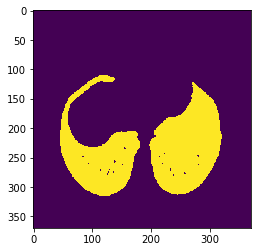

In [150]:
plt.figure(3)
plt.imshow(meaned_normed_segmented_lungs[81])#, cmap=plt.cm.gray)
plt.show()

# 从原始数据提取特征
1. 去均值
2. 规范化
3. 直方图均衡

In [214]:
def get_patient_img_np(patient_path):
    slices = [dicom.read_file(patient_path + '/' + s) for s in os.listdir(patient_path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [ ]:
def calc_features(feature_save_path):
    # 加载网络模型和参数
    net = get_extractor()
    
    for idx in xrange(len(unextracted_patients_folder_path)):
        folder_path = unextracted_patients_folder_path[idx]
        batch = get_data_id(folder_path)
        feats = net.predict(batch)
        print(idx,feats.shape)
        np.save(feature_save_path, feats)

In [215]:
patient_img_np = get_patient_img_np("/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/"+patient_id)
print patient_img_np.shape
print patient_img_np.dtype

(146, 512, 512)
int16


In [216]:
# 对当前路径的病人所有图像合成三通道的图像
# 最终得到 n 张三通道图像，即四维numpy数组
def get_composed_patient_4d(patient_path, resize_tuple=(224, 224), dx=40, ds=512):
    # 读取病人图像数据为numpy数组
    patient_img_np = get_patient_img_np(patient_path)
    #patient_img_np[patient_img_np == -2000] = 0
    # 设定扫描外围的像素值为0
    # 截距通常为-1024，所以空气约为0
    # image[image == -2000] = 0
    outside_img = patient_img_np.min()
    patient_img_np[patient_img_np == outside_img] = 0
    
    # patient_4d:四维numpy数组[n, 3, x, y]，有n张三通道的图
    # 通过dx和ds对图像上下左右的空气边沿去掉，这两个值是人为定义的
    patient_4d = []
    dx = dx
    ds = ds
    
    # 根据当前病人的所有图像切片合成三通道数据
    for comp_idx in xrange(0, patient_img_np.shape[0] - 3, 3):
        # 每个comp_3channel_img_list是三幅2D图像
        # 即这个list中有三个元素，每个元素都是一个2D图像(一个通道)
        comp_3channel_img_list = []
        for channel_idx in xrange(3):
            img = patient_img_np[comp_idx + channel_idx]
            # 这部分包含两个步骤：去均值(0.25)，并规范化，
            # 之后将值映射到[0, 255]区间上
            img = 255.0 / np.amax(img) * (1-0.25) * img
            # 直方图均衡化
            img = cv2.equalizeHist(img.astype(np.uint8))
            img = img[dx: ds - dx, dx: ds - dx]
            # 我加入下面这行将图像上面几行的冗余去除
            img = img[2*dx:, :]
            img = cv2.resize(img, resize_tuple)
            comp_3channel_img_list.append(img)
            
        # 每个comp_3channel_img_list是三幅2D图像把结果追加保存到patient_4d列表
        # comp_3channel_img_list是3D的
        # patient_4d是4D的(第comp_idx捆三张打包，三张打包中的第channel_idx张，
        # 第channel_idx张的第k行，第j张的第m列)
        comp_3channel_img_list = np.array(comp_3channel_img_list)
        patient_4d.append(np.array(comp_3channel_img_list))

    # 整个batch再次转化为numpy
    patient_4d = np.array(patient_4d)
    return patient_4d

(48, 3, 224, 224)
255
0


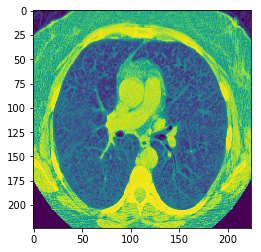

In [219]:
raw_patient_data_path = "/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/"
patient_4d = get_composed_patient_4d(raw_patient_data_path + patient_id)
print patient_4d.shape
print patient_4d.max()
print patient_4d.min()
plt.figure()
plt.imshow(patient_4d[20][1])#, cmap=plt.cm.gray)
plt.show()

In [101]:
print path

/media/yuens/WIN10-ENTERTENMENT/Kaggle/DSB2017/stage1/*


# 第四步：特征提取

注：这里先跳过所有病人的数据获取，上面已经是给出读取一个病人的数据并保存的例子。下面将继续提取特征的部分，因为想将读取数据和提取特征结合到一起，完成提取特征后再考虑将代码整合。

## 4.1 用ResNet-50提取特征
特征提取采用预训练过的ResNet-50，该网络预训练采用的数据是imagenet-11k-place365-ch。网络模型可以在mxnet的[model文件夹](http://data.dmlc.ml/mxnet/models/imagenet-11k-place365-ch/)中找到。

In [ ]:
def get_extractor():
    model = mx.model.FeedForward.load('/home/yuens/Downloads/code/mxnet_inference/resnet/resnet-50',\
                                      0, ctx=mx.cpu(), numpy_batch_size=1)
    # model.symbol.get_internals函数
    # 让模型获取一个内部某层输出，并和网络输出结合组成(group)出一个新模型
    fea_symbol = model.symbol.get_internals()["flatten0_output"]
    feature_extractor = mx.model.FeedForward(ctx=mx.cpu(), symbol=fea_symbol, numpy_batch_size=64,
                                             arg_params=model.arg_params, aux_params=model.aux_params,
                                             allow_extra_params=True)

    return feature_extractor

## ResNet-50网络可视化

根据网络的参数和配置json文件，对网络进行可视化。可视化有两种方法：
1. 在Jupyter Notebook里可视化。不要将核心的`mx.viz.plot_network`这行代码封装成函数，否则不会打印在notebook里；
2. 将可视化结果保存成文件和对应digraph plot文件（我封装成了函数）。

In [ ]:
# 第一种方式：直接在Jupyter Notebook中可视化

# 初始化必要参数
prefix = '/home/yuens/Downloads/code/mxnet_inference/resnet/resnet-50'
epoch = 0
data_shape = (1, 1, 299, 299)
save_filename = "visualized_ResNet-50"

# 导入包
import mxnet as mx
import importlib

# 加载模型并根据模型symbol进行可视化
# 主要就是下面这两行代码：参考了官方教程，
#                   但是官方教程是通过mx.mod.FeedForward加载模型参数的，
#                   我这里失败了，所以直接通过check_point加载。
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, epoch)
mx.viz.plot_network(sym, shape={"data":data_shape}, node_attrs={"shape":'rect', "fixedsize":'false'}) 

不难发现，可视化后的结果超大，不方便查看。下面我们将继续第二种方法，将可视化结果保存到pdf文件中。

In [ ]:
# 第二种方式：将可视化结果保存到pdf文件中
#           此外，也会保存对应的配置digraph plot参数文件

def save_visualized_network(prefix, epoch=0, data_shape=(1, 1, 299, 299), save_filename="visualized_network.pdf"):
    # 这里和上面基本一致，只是在最后多了一个reader的过程，就是将结果保存到指定的文件中
    sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, epoch)
    net_viz = mx.viz.plot_network(sym,
                                  shape={"data":data_shape},
                                  node_attrs={"shape":'rect',
                                              "fixedsize":'false'}
                                 )
    net_viz.render(save_filename)

# 初始化必要的参数
prefix = '/home/yuens/Downloads/code/mxnet_inference/resnet/resnet-50'
epoch = 0
data_shape = (1, 1, 299, 299)
save_filename = "visualized_ResNet-50"

# 执行保存可视化网络结果的函数
save_visualized_network(prefix, epoch, data_shape, save_filename)

## CT图像可视化
这里可视化有两种方式：
1. 二维可视化
2. 三维可视化（将二维图像序列重建为三维）